<a href="https://colab.research.google.com/github/FGalvao77/Aplicando-os-algoritmos-KMeans-e-LogisticRegression-utilizando-o-PySpark/blob/main/Aplica%C3%A7%C3%A3o_pr%C3%A1tica_dos_algoritmos_KMeans_e_LogisticRegression_utilizando_o_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplicação prática dos algoritmos _KMeans_ e _LogisticRegression_ utilizando o `PySpark`**

---



Primeiro vamos configurar o ambiente do _google colab_ para utilização do `PySpark`.

In [1]:
# instalando as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install -q pyspark

In [2]:
# configurando as variáveis de ambiente
import os

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'

# tornando o pyspark "importável"
import findspark
findspark.init()

In [3]:
# vamos ver se os diretórios/dependências necessita de atualizações
!apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [4]:
# atualizando os diretórios/dependências
!apt upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... Done
The following packages have been kept back:
  libcudnn8 libcudnn8-dev libnccl-dev libnccl2
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [5]:
# removendo aplicações obsoletas
!apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [6]:
# instalando o PySpark
# !pip install pyspark

**Inicializando a sessão do Spark**

Segundo passao, precisamos inicializar a sessão do Spark.

In [7]:
# importando a biblioteca para iniciar a sessão spark
from pyspark.sql import SparkSession

In [8]:
# iniciando a sessão spark
spark = SparkSession.builder\
    .appName('PySpark MLlib - KMeans | LogisticRegression')\
    .getOrCreate()

In [9]:
# visualizando a sessão instanciada
spark

## **KMeans**

**Encontrando Hackers com PySpark MLlib**

Um sistema da empresa foi hackeado e muitos dados foram roubados. Felizmente, os metadados de cada sessão usada pelos hackers para se conectar foram gravados e estão disponíveis para nós. Existem 3 possíveis hackers, ou até mais.

Uma prática comum entre os hackers é a compensação do trabalho. Isso significa que os hackers fazem aproximadamente a mesma quantidade de hacks. 

- **Descrição do problema:**

 Encontrar o número de hackers que invadiu o sistema. Então, vamos usar o _clustering_ para descobrir o número de hackers.

**Carregando o conjunto de dados**

Primeiro importaremos o conjunto de dados e para em seguida, utilizando o método `spark.read.csv` para realizarmos a leitura do mesmo. 

In [10]:
# importando o conjunto de dados
!wget 'https://raw.githubusercontent.com/farhanafayez/PySpark-K-means-Clustering-ML/master/hack_data.csv'

--2021-12-04 00:25:19--  https://raw.githubusercontent.com/farhanafayez/PySpark-K-means-Clustering-ML/master/hack_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14268 (14K) [text/plain]
Saving to: ‘hack_data.csv.1’

hack_data.csv.1     100%[===================>]  13.93K  --.-KB/s    in 0s      

2021-12-04 00:25:19 (70.8 MB/s) - ‘hack_data.csv.1’ saved [14268/14268]



In [11]:
# visualizando o conjunto de dados
!head hack_data.csv

Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
8.0,391.09,1,2.96,7.0,Slovenia,72.37
20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08
31.0,356.32,1,3.71,8.0,Tokelau,70.58
2.0,228.08,1,2.48,8.0,Bolivia,70.8
20.0,408.5,0,3.57,8.0,Iraq,71.28
1.0,390.69,1,2.79,9.0,Marshall Islands,71.57
18.0,342.97,1,5.1,7.0,Georgia,72.32
22.0,101.61,1,3.03,7.0,Timor-Leste,72.03
15.0,275.53,1,3.53,8.0,Palestinian Territory,70.17


In [12]:
# carregando o conjunto de dados e instanciando no objeto "df"
df = spark.read.csv('/content/hack_data.csv', 
                    header = True, 
                    inferSchema = True)

**Esquema dos dados recuperados**

Vamos dar uma olhada no esquema de dados para entender melhor com o que estamos lidando.

In [13]:
# visualizando o tipo de dado de cada atributo
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [14]:
# quantidade de observações presente no conjunto de dados
df.count()

334

In [15]:
# visualizando as 5 primeiras linhas
df.head(5)

[Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37),
 Row(Session_Connection_Time=20.0, Bytes Transferred=720.99, Kali_Trace_Used=0, Servers_Corrupted=3.04, Pages_Corrupted=9.0, Location='British Virgin Islands', WPM_Typing_Speed=69.08),
 Row(Session_Connection_Time=31.0, Bytes Transferred=356.32, Kali_Trace_Used=1, Servers_Corrupted=3.71, Pages_Corrupted=8.0, Location='Tokelau', WPM_Typing_Speed=70.58),
 Row(Session_Connection_Time=2.0, Bytes Transferred=228.08, Kali_Trace_Used=1, Servers_Corrupted=2.48, Pages_Corrupted=8.0, Location='Bolivia', WPM_Typing_Speed=70.8),
 Row(Session_Connection_Time=20.0, Bytes Transferred=408.5, Kali_Trace_Used=0, Servers_Corrupted=3.57, Pages_Corrupted=8.0, Location='Iraq', WPM_Typing_Speed=71.28)]

In [16]:
# visualizando as 5 primeiras linhas de forma estrutura como tabela
df.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [17]:
# estatística descritiva do conjunto de dados
df.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

In [18]:
# estatística descritiva de um atributo específico
df.select('Bytes Transferred').describe().show()

+-------+------------------+
|summary| Bytes Transferred|
+-------+------------------+
|  count|               334|
|   mean| 607.2452694610777|
| stddev|286.33593163576757|
|    min|              10.0|
|    max|            1330.5|
+-------+------------------+



In [19]:
# estatística descritiva de dois atributos específicos
df.select('Bytes Transferred', 'Kali_Trace_Used').describe().show()

+-------+------------------+------------------+
|summary| Bytes Transferred|   Kali_Trace_Used|
+-------+------------------+------------------+
|  count|               334|               334|
|   mean| 607.2452694610777|0.5119760479041916|
| stddev|286.33593163576757|0.5006065264451406|
|    min|              10.0|                 0|
|    max|            1330.5|                 1|
+-------+------------------+------------------+



In [20]:
# estatística descritiva do conjunto de dados, utilizando a função ".toPandas()"
df.describe().toPandas()

,summary,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,count,334,334,334,334,334,334,334
1,mean,30.008982035928145,607.2452694610777,0.5119760479041916,5.258502994011977,10.838323353293413,None,57.342395209580864
2,stddev,14.088200614636158,286.33593163576757,0.5006065264451406,2.30190693339697,3.06352633036022,None,13.41106336843464
3,min,1.0,10.0,0,1.0,6.0,Afghanistan,40.0
4,max,60.0,1330.5,1,10.0,15.0,Zimbabwe,75.0


In [21]:
# estatística descritiva de um atributo específico
df.select('Session_Connection_Time').describe().toPandas()

,summary,Session_Connection_Time
0,count,334
1,mean,30.008982035928145
2,stddev,14.088200614636158
3,min,1.0
4,max,60.0


In [22]:
# estatística descritiva de dois atributos específicos
df.select('Session_Connection_Time', 'Pages_Corrupted')\
    .describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Session_Connection_Time,334,30.008982035928145,14.088200614636158,1.0,60.0
Pages_Corrupted,334,10.838323353293413,3.06352633036022,6.0,15.0


**Importando o `VectorAssembler` e criando os recursos necessários para aplicação do modelo**

Devemos transformar os dados do tipo numérico usando a função `VectorAssembler` em uma única coluna onde cada linha do DataFrame contém um vetor de recurso. Para criar nossos clusters, precisamos selecionar colunas com base nas quais criaremos nossa coluna de recursos. São elas:

- Session_Connection_Time
- Bytes transferidos
- Kali_Trace_Used
- Servers_Corrupted
- Pages_Corrupted
- WPM_Typing_Speed

In [23]:
# importando os algoritmos "Vectors" e "VectorAssembler"
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [24]:
# visualizando o nome dos atributos
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

In [25]:
# instanciando os atributos de interesse
feat_cols = ['Session_Connection_Time',
             'Bytes Transferred',
             'Kali_Trace_Used',
             'Servers_Corrupted',
             'Pages_Corrupted',
             'WPM_Typing_Speed']

In [26]:
# aplicando a transformação das instâncias das colunas de interesse
vec_assembler = VectorAssembler(inputCols = feat_cols, 
                                outputCol = 'features')

# instanciando o resultado em um dataframe
final_df = vec_assembler.transform(df)

In [27]:
# visualizando as 5 primeiras linhas do objeto dataframe criado
final_df.show(5)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|            features|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|[8.0,391.09,1.0,2...|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|[20.0,720.99,0.0,...|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|[31.0,356.32,1.0,...|
|                    2.0|           228.08|              1|             2.48|     

**Importando a biblioteca `StandardScaler`**

A centralização e o escalonamento acontecem independentemente em cada recurso, computando as estatísticas relevantes nas amostras do conjunto de treinamento. A _média_ e o _desvio padrão_ são então armazenados para serem usados ​​em dados posteriores usando o método de transformação.

A padronização de um conjunto de dados é um requisito comum para muitos estimadores de aprendizado de máquina, pois eles podem se comportar mal se o recurso individual não se parecer mais ou menos com dados normalmente distribuídos.

In [28]:
# importando a biblioteca para escalonamento dos dados
from pyspark.ml.feature import StandardScaler

In [29]:
# instanciando o algoritmo no objeto "scaler" e passando como argumentos:
# de entrada o atributo "features" e de saída o "scaled_feats"
scaler = StandardScaler(inputCol = 'features', 
                        outputCol = 'scaled_feats', 
                        withStd = True,               # desvio padrão 
                        withMean = False)             # média

**Estatísticas de resumo de computação**

Vamos calcular as estatísticas de resumo ajustando o StandardScaler. Em seguida, normalize cada recurso para ter um desvio padrão da unidade.

In [30]:
# treinado o modelo para escalonar os dados do objeto "final_df"
scaler_model = scaler.fit(final_df)

# o resultado final armazenaremos no objeto "cluster_final_data"
cluster_final_data = scaler_model.transform(final_df)

In [31]:
# visualizando as  primeiras linhas do objeto criado acima
cluster_final_data.show(3)

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|            features|        scaled_feats|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+--------------------+--------------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|[8.0,391.09,1.0,2...|[0.56785108466505...|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|[20.0,720.99,0.0,...|[1.41962771166263...|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58

**Construindo o modelo KMeans e calculando a Silhueta com distância euclidiana quadrada**

Precisamos primeiro construir nosso modelo. O número de clusters desejados é então passado para o algoritmo. Em seguida, calculamos a Silhueta com distância euclidiana quadrada. 

Usamos os valores derivados deles para descobrir se temos 2 ou 3 hackers.

**Importando o algortimo `KMeans`**


In [32]:
# importando o algoritmo KMeans
from pyspark.ml.clustering import KMeans

In [33]:
# importando o algoritmo para visualização do score do modelo
from pyspark.ml.evaluation import ClusteringEvaluator

In [34]:
# configurando o objeto avaliador
eval = ClusteringEvaluator(predictionCol = 'prediction', 
                           featuresCol = 'scaled_feats', 
                           metricName = 'silhouette', 
                           distanceMeasure = 'squaredEuclidean')

In [35]:
# aplicando o modelo e visualiando o score para cada número de clusters
silhouette_score = []

print('''
Sihouette scores - KMeans Clustering
++++++++++++++++++++++++++++++++++++
\n\tModel\tScore\t
\t=====\t=====\t''')

for k in range(2, 11):
    model_kmeans = KMeans(featuresCol='scaled_feats', k=k)
    model_fit = model_kmeans.fit(cluster_final_data)
    output = model_fit.transform(cluster_final_data)
    score = eval.evaluate(output)
    silhouette_score.append(score)
    print(f'\tK = {k}\t{round(score, 2)}\t')


Sihouette scores - KMeans Clustering
++++++++++++++++++++++++++++++++++++

	Model	Score	
	=====	=====	
	K = 2	0.82	
	K = 3	0.76	
	K = 4	0.72	
	K = 5	0.63	
	K = 6	0.52	
	K = 7	0.57	
	K = 8	0.5	
	K = 9	0.45	
	K = 10	0.39	


In [36]:
# biblioteca para visualização gráfica
import matplotlib.pyplot as plt

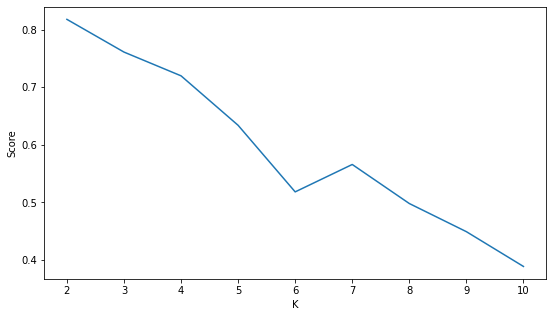

In [37]:
# visualizando graficamente o score em realação a quantidade de clusters
fig, ax = plt.subplots(1, 1, figsize = [9, 5])
ax.plot(range(2, 11), silhouette_score)
ax.set_xlabel('K')
ax.set_ylabel('Score');

**Verificação final do número de hackers**

Vamos descobrir quantos hackers estiveram envolvidos com base no número de hacks feitos.

In [38]:
# modelo com 3 clusters
model_kmeans3 = KMeans(featuresCol='scaled_feats', k=3)
model_k3 = model_kmeans3.fit(cluster_final_data)
model_k3.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         2|   79|
|         0|   88|
+----------+-----+



In [39]:
# modelo com 2 clusters
model_kmeans2 = KMeans(featuresCol='scaled_feats', k=2)
model_k2 = model_kmeans2.fit(cluster_final_data)
model_k2.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



> Aqui podemos ver que para 3 hackers, nosso modelo produziu 167, 79 e 88 hackers. Isso não é possível porque os hackers geralmente dividem as tarefas entre eles. Em nosso modelo onde K = 2, obtemos 167 número de hacks para ambos os hackers. Portanto, havia apenas 2 hackers envolvidos.

In [40]:
# kmeans3 = KMeans(featuresCol='scaledFeatures', k=3)
# kmeans2 = KMeans(featuresCol='scaledFeatures', k=2)

In [41]:
# treinando o modelo com k=2
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(cluster_final_data)

# realizando as predições com o modelo após o seu treinamento
predictions = model.transform(cluster_final_data)

# avaliando o agrupamento  e calculando a pontuação do "Silhouette"
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print('Silhouette with squared euclidean distance = ' + str(silhouette))

# visualizando os resultados
centers = model.clusterCenters()
print('\nCluster Centers [K=2]: ')
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.8048521975748283

Cluster Centers [K=2]: 
[4.00060976e+01 8.59157866e+02 5.36585366e-01 6.92634146e+00
 1.32134146e+01 4.68612195e+01]
[ 20.36470588 364.22370588   0.48823529   3.64952941   8.54705882
  67.45364706]


In [42]:
# treinando o modelo com k=2
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(cluster_final_data)

# realizando as predições com o modelo após o seu treinamento
predictions = model.transform(cluster_final_data)

# avaliando o agrupamento  e calculando a pontuação do "Silhouette"
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print('Silhouette with squared euclidean distance = ' + str(silhouette))

# visualizando os resultados
centers = model.clusterCenters()
print('\nCluster Centers [K=3]: ')
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6958546319645178

Cluster Centers [K=3]: 
[2.86210526e+01 5.91309684e+02 5.47368421e-01 5.12989474e+00
 1.04315789e+01 5.86424211e+01]
[ 18.27192982 286.43087719   0.45614035   3.16122807   8.01754386
  70.10263158]
[4.1768000e+01 9.1193904e+02 5.3600000e-01 7.2689600e+00 1.3720000e+01
 4.4717040e+01]


In [43]:
# kmeans_k2 = KMeans().setK(2).setSeed(1)
# model_k2 = kmeans_k2.fit(cluster_final_data.select('features'))
# predictions = model_k2.transform(cluster_final_data.select('features'))

# evaluator = ClusteringEvaluator()
# silhouette = evaluator.evaluate(predictions)
# print('Silhouette with squared euclidean distance = ' + str(silhouette))

# centers = model.clusterCenters()
# print('\nCluster Centers [K=2]: ')

# for center in centers:
#     print(center)

In [44]:
# kmeans_k3 = KMeans().setK(3).setSeed(1)
# model_k3 = kmeans_k3.fit(cluster_final_data.select('features'))
# predictions = model_k3.transform(cluster_final_data.select('features'))

# evaluator = ClusteringEvaluator()
# silhouette = evaluator.evaluate(predictions)
# print('Silhouette with squared euclidean distance = ' + str(silhouette))

# centers = model.clusterCenters()
# print('\nCluster Centers [K=3]: ')

# for center in centers:
#     print(center)

## **LogisticRegression**

**Previsão de rotatividade do cliente com PySpark MLlib**

A _previsão do churn_ é um grande negócio. Ele minimiza a deserção do cliente ao prever quais clientes provavelmente cancelarão a assinatura de um serviço. Embora originalmente usado no setor de telecomunicações, tornou-se uma prática comum em bancos, ISPs, seguradoras e outros segmentos.

O processo de previsão é fortemente orientado por dados e frequentemente utiliza técnicas avançadas de aprendizado de máquina. Aqui, veremos quais tipos de dados de cliente são normalmente usados, faremos algumas análises preliminares dos dados e geraremos modelos de previsão de rotatividade - tudo com o `PySpark` e suas estruturas de aprendizado de máquina.

- **Descricão do problema:**

 Uma agência de marketing tem muitos clientes que usam seus serviços para produzir anúncios para os sites de clientes/consumidores. Eles perceberam que há uma grande rotatividade de clientes. 
 
 Eles basicamente atribuem gerentes de conta de forma aleatória agora, mas querem que você crie um modelo de aprendizado de máquina que ajudará a prever quais clientes abandonarão (pararão de comprar seu serviço) para que possam atribuir corretamente os clientes com maior risco a dispensar um gerente de conta. 
 
 Felizmente, eles têm alguns dados históricos.

**Importando os dados de treinamento e teste**

Importando os dados de treinamento e os dados de teste (dados de entrada para fins de teste).

In [45]:
# !wget 'https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv'
# !wget 'https://raw.githubusercontent.com/albayraktaroglu/Datasets/master/churn.csv'
!wget 'https://raw.githubusercontent.com/FGalvao77/datasets/main/customer_churn.csv'

--2021-12-04 00:26:09--  https://raw.githubusercontent.com/FGalvao77/datasets/main/customer_churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115479 (113K) [text/plain]
Saving to: ‘customer_churn.csv.4’

customer_churn.csv. 100%[===================>] 112.77K  --.-KB/s    in 0.02s   

2021-12-04 00:26:09 (6.97 MB/s) - ‘customer_churn.csv.4’ saved [115479/115479]



In [46]:
# visualizando o conjunto de dados
# !head WA_Fn-UseC_-Telco-Customer-Churn.csv
# !head churn.csv
!head customer_churn.csv

Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
Cameron Williams,42.0,11066.8,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
Kevin Mueller,41.0,11916.22,0,6.5,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 17756",Wilson PLC,1
Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1
Jessica Williams,48.0,10356.02,0,5.12,8.0,2009-03-03 23:13:37,"6187 Olson Mountains East Vincentborough, PR 74359",Kelly-Warren,1
Eric Butler,44.0,11331.58,1,5.23,11.0,2016-12-05 03:35:43,"4846 Savannah Road West Justin, IA 87713-3460",Reynolds-Sheppard,1
Zachary Walsh,32.0,9885.12,1,6.92,9.0,2006-03

In [47]:
# PATH = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'
# PATH = '/content/churn.csv'
PATH = '/content/customer_churn.csv'

In [48]:
# carregando o conjunto de dados e instanciando no objeto "df"
df = spark.read.csv(PATH, 
                    header = True, 
                    inferSchema = True)

**Esquema de Dados**

In [49]:
# visualizando o tipo de dado em cada atributo
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



> O atributo `Churn` é a nossa variável alvo.

In [50]:
# visualizando as 5 primeiras linhas do conjunto de dados
df.show(5)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|  Cynthia Norton|37.0|    

In [51]:
# contabilizando a quantidade observações presente no conjunto de dados
df.count()

900

In [52]:
# dividindo o conjunto de dados em dados para modelagem e dados para teste
data_modeling, test_data = df.randomSplit([0.7,0.3]) 

In [53]:
# visualizando a quantidade de instâncias em cada novo objeto
data_modeling.count(), test_data.count()

(640, 260)

In [54]:
# visualizando as 5 primeiras linhas dos dados para modelagem
data_modeling.show(5)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|      Aaron King|46.0|       7504.79|              0| 5.98|      8.0|2007-05-13 20:42:11|38346 Smith Prair...|       Hernandez PLC|    0|
|     Aaron Meyer|45.0|       9598.03|              0|  5.0|      7.0|2010-07-17 03:30:38|35821 Bailey Skyw...|Steele, Bates and...|    0|
|      Aaron West|55.0|      10056.55|              0| 4.98|      8.0|2006-09-01 06:11:47|071 Schmidt Locks...|Cruz, Russell and...|    0|
|Abigail Gonzalez|55.0|       8243.28|              0| 3.54|      6.0|2014-01-09 19:52:37|325 Lawrence Cros...|          Nelson PLC|    0|
|      Adam Gomez|48.0|    

In [55]:
# visualizando as 5 primeiras linhas dos dados para teste
test_data.show(5)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Abigail Jennings|36.0|      12309.23|              1| 4.76|      9.0|2012-03-11 17:10:26|USS Mcgrath FPO A...|Simpson, Byrd and...|    0|
|     Adam Harris|44.0|       9815.03|              1|  4.9|      9.0|2016-05-29 06:00:09|40488 Michael For...|Smith, Oconnor an...|    0|
|      Adam Moore|41.0|      12659.88|              0| 4.55|      4.0|2010-01-22 19:08:48|339 Jeffrey River...|Little, White and...|    0|
|   Adriana James|36.0|      10448.09|              0| 4.13|      8.0|2016-04-09 09:02:14|USNV Ferguson FPO...|Doyle, Butler and...|    0|
|       Alan Gray|29.0|    

In [56]:
# visualizando o tipo de dado em cada atributo dos dados para modelagem
data_modeling.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



**Usando o `Vector` e o `VectorAssembler`**

In [57]:
# importando as bibliotecas
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# instanciando o objeto e seus argumentos:
# atributos de entrada e saída
assembler = VectorAssembler(inputCols = ['Age','Total_Purchase','Account_Manager','Years','Num_Sites'],
                            outputCol = 'features')

# instanciando o resultado no objeto "output_data"
output_data = assembler.transform(data_modeling)

In [58]:
# visualizando as 3 primeiras linhas 
output_data.show(3)

+-----------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+--------------------+
|      Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|            features|
+-----------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+--------------------+
| Aaron King|46.0|       7504.79|              0| 5.98|      8.0|2007-05-13 20:42:11|38346 Smith Prair...|       Hernandez PLC|    0|[46.0,7504.79,0.0...|
|Aaron Meyer|45.0|       9598.03|              0|  5.0|      7.0|2010-07-17 03:30:38|35821 Bailey Skyw...|Steele, Bates and...|    0|[45.0,9598.03,0.0...|
| Aaron West|55.0|      10056.55|              0| 4.98|      8.0|2006-09-01 06:11:47|071 Schmidt Locks...|Cruz, Russell and...|    0|[55.0,10056.55,0....|
+-----------+----+--------------+---------------+-----+---------+-----

In [59]:
# visualizando o tipo de dado em cada atributo
output_data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- features: vector (nullable = true)



> Como podemos observar, temos um novo atributo, `features` que será a base da modelo de classificação.

**Usando Regressão Logística nos dados**

In [60]:
# importando a biblioteca
from pyspark.ml.classification import LogisticRegression

In [61]:
# criando dados finais com apenas 2 colunas
final_data = output_data.select('features','churn')    

# divisão dos dados em treino e teste
train_data, val_data = final_data.randomSplit([0.7,0.3])          

# criando o modelo
model_lr = LogisticRegression(labelCol = 'churn')           

# treinando o modelo com os dados de treino
model = model_lr.fit(train_data)        
 
 # resumo das previsões sobre os dados de treinamento
summary=model.summary
summary.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|              churn|         prediction|
+-------+-------------------+-------------------+
|  count|                448|                448|
|   mean|0.18303571428571427|0.13839285714285715|
| stddev| 0.3871281037899569| 0.3456978897828559|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



**Importando o BinaryClassificationEvaluator**


A avaliação de classificadores binários compara dois métodos de atribuição de um atributo binário, um dos quais geralmente é um método padrão e o outro está sendo investigado. Existem muitas métricas que podem ser usadas para medir o desempenho de um classificador ou preditor; campos diferentes têm preferências diferentes para métricas específicas devido a objetivos diferentes.

In [62]:
# importando a biblioteca
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# realizando as predições com o modelo com os dados de validação
predictions = model.evaluate(val_data)

In [63]:
# visualizando as classes
predictions.labels

[0.0, 1.0]

A seguir, criaremos um avaliador e usaremos o avaliador de classificação binária para prever a rotatividade.

In [64]:
# instanciando o avaliador
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction',
                                          labelCol = 'churn')

# aplicando o avaliador nas predições
evaluator.evaluate(predictions.predictions)
 
# instanciando o modelo
model1 = LogisticRegression(labelCol = 'churn')

# realizando o treinamento com os dados "final_data"
model1 = model1.fit(final_data)

# realizando as transformações nos dados de teste
test_final = assembler.transform(test_data)

**Resultados da descoberta**

Agora vamos usar o modelo para avaliar os dados de teste (test_data).

In [69]:
# aplicando o "model1" nos dados de teste após sua transformação
results = model1.transform(test_final)

# visualizando o resultado das predições
results.select('Company','prediction').show(50)

+--------------------+----------+
|             Company|prediction|
+--------------------+----------+
|Simpson, Byrd and...|       0.0|
|Smith, Oconnor an...|       0.0|
|Little, White and...|       0.0|
|Doyle, Butler and...|       0.0|
|         Mendoza Inc|       0.0|
|Mann, Roberts and...|       0.0|
|      Jones and Sons|       0.0|
|   Campbell and Sons|       0.0|
|Green, Jackson an...|       0.0|
|Jordan, Beasley a...|       0.0|
|Davis, Mccormick ...|       0.0|
|Nelson, Ray and J...|       0.0|
|          Parker PLC|       0.0|
|Johnson, Fields a...|       0.0|
|Barron, Tapia and...|       0.0|
|Conner, Brown and...|       0.0|
|      Woodward-Bruce|       0.0|
|      Miller-Ramirez|       0.0|
|       Miranda-Sloan|       0.0|
|Brown, Johnson an...|       0.0|
|        Knight-Price|       0.0|
|   Williamson-Walker|       0.0|
|Jones, Reyes and ...|       0.0|
|Benitez, Durham a...|       0.0|
|Johnson, Ingram a...|       0.0|
|          Brooks Inc|       0.0|
|Fisher, Moore

> Aqui podemos ver o cliente potencial que pode deixar a de adquirir os serviços da empresa.